In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
from math import ceil,sin,cos, atan2, pi, sqrt
import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)
config='/home/jvalenti/MOAD/analysis-jose/OParcels/neutral_iona.yaml'

In [3]:
param = load_config1(config)
start = datetime(param['startdate']['year'], param['startdate']['month'], param['startdate']['day']) #Start date
Tmax = param['param']['length'] # Set Time length [days] 
duration = timedelta(days=Tmax)
dt = param['param']['dt'] #toggle between - or + to pick backwards or forwards 
N = param['param']['N'] # number of deploying locations
n = param['param']['n'] # 1000   # number of particles per location
dmin = param['param']['dmin'] #minimum depth
dd = param['param']['dd'] #max depth difference from dmin
name = param['file']['name'] #name output file

daterange = [start+timedelta(days=i) for i in range(Tmax)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)

In [4]:
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]

In [5]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

In [6]:
surf = ds.beached
age = ds.tau
lat = ds.lat
lon = ds.lon
time = ds.time
resurf = []
lonsurf = []
latsurf = []
times = []

for i in range (age.shape[0]):
    if np.argmax(np.array(surf[i,:])==6)==0:
        if np.array(surf[i,:]==6)[0]:
            resurf.append(age[i,np.argmax(np.array(surf[i,:])==6)].values.item())   
            lonsurf.append(lon[i,np.argmax(np.array(surf[i,:])==6)].values.item())  
            latsurf.append(lat[i,np.argmax(np.array(surf[i,:])==6)].values.item()) 
        else:
            resurf.append(np.nan)
            latsurf.append(np.nan)
            lonsurf.append(np.nan)
    else:
        resurf.append(age[i,np.argmax(np.array(surf[i,:])==6)].values.item())   
        lonsurf.append(lon[i,np.argmax(np.array(surf[i,:])==6)].values.item())   
        latsurf.append(lat[i,np.argmax(np.array(surf[i,:])==6)].values.item())   
    #times.append(time[i,np.argmax(np.array(surf[i,:])==6)].values.item())   
    

In [7]:
days = (np.array(resurf)/86400)
daysm = []
for i in range(200):
    daysm.append(np.nanmean(days[i*50:(i+1)*50]))

latm = []
lonm = []
for i in range(200):
    latm.append(np.nanmean(latsurf[i*50:(i+1)*50]))
    lonm.append(np.nanmean(lonsurf[i*50:(i+1)*50]))

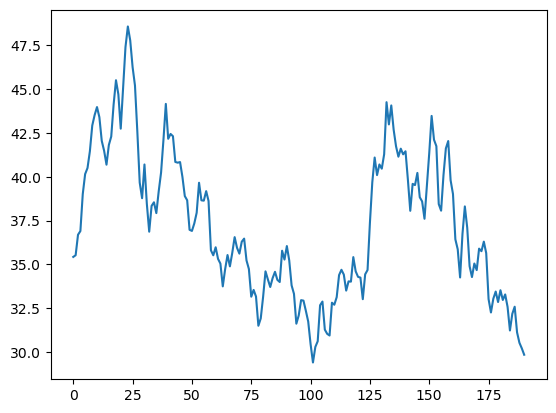

In [8]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
#plt.plot(daysm)
b = moving_average(daysm, n=10)
plt.plot(b)

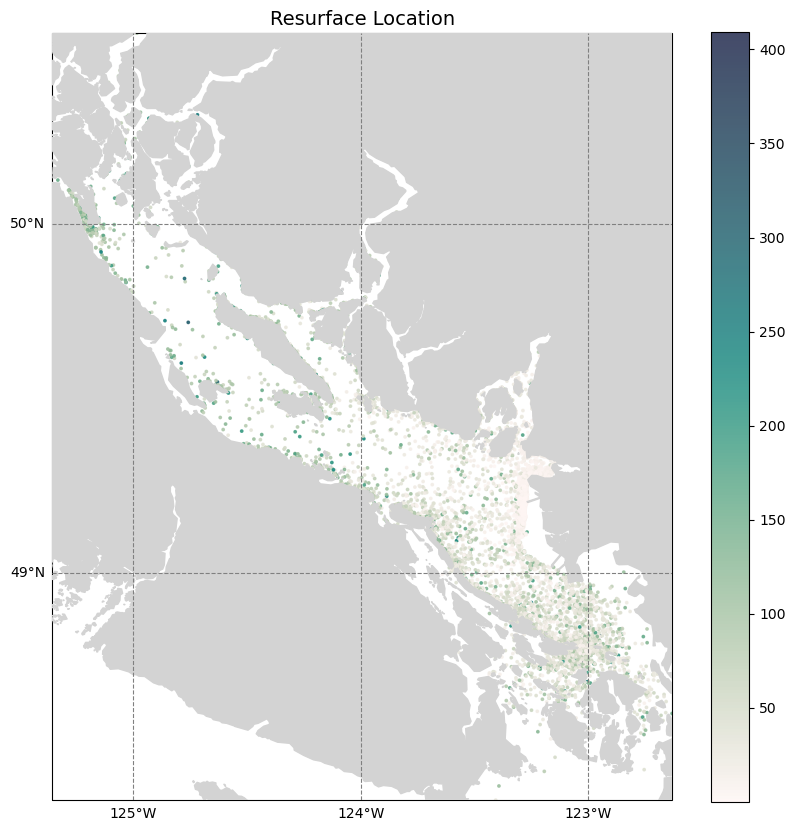

In [21]:
lonmin= np.nanmin(lonsurf)
lonmax= np.nanmax(lonsurf)
latmin= np.nanmin(latsurf)
latmax= np.nanmax(latsurf)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('high', facecolor='lightgray',edgecolor='lightgray'),zorder=4)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False
plt.title('Resurface Location',fontsize='14')
#sc=plt.scatter(lonsurf[:500],latsurf[:500],transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=1)
#bad_indices = np.isnan(lonsurf)
#good_indices = ~bad_indices
#lonsurf = np.array(lonsurf)
#latsurf = np.array(latsurf)
#good_x = lonsurf[good_indices]
#good_y = latsurf[good_indices]
#aa=plt.hist2d(good_x,good_y,100,norm = colors.LogNorm(), cmap =cmocean.cm.dense,zorder=1)
sc=plt.scatter(lonsurf,latsurf,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=3,c=days,cmap=cmocean.cm.tempo)
plt.colorbar(sc)

In [81]:
res = ds.beached[:200*50,:]
a = 0
for i in range(len(res)):
    if 6 in ds.beached[i,:]:
        a+=1
print(f'{(a/len(res))*100}% of the particles resurfaced in the run time.')

99.59% of the particles resurfaced in the run time.


In [11]:
# beach = ds.beached

# b = []
# b2 = []
# b3 =[]
# for t in range(beach.shape[1]):
#     a=np.count_nonzero(beach[:,t] == 0.0)
#     a2=np.count_nonzero(beach2[:,t] == 0.0)
#     a3=np.count_nonzero(beach3[:,t] == 0.0)
#     c=np.count_nonzero(beach[:,t] == 1.0)
#     c2=np.count_nonzero(beach2[:,t] == 1.0)
#     c3=np.count_nonzero(beach3[:,t] == 1.0)
#     b.append(c/(c+a))
#     b2.append(c2/(c2+a2))
#     b3.append(c3/(c3+a3))
# time = np.linspace(0,5,121)
# fig,axs = plt.subplots(1,1,figsize=(10,5))
# #plt.plot(time,b,label='100 m')
# plt.plot(time,b2,label='500 m')
# plt.plot(time,b3,label='50 m')
# plt.axvline(x=time_prob(50,1)[0],linestyle='--',color='grey')
# plt.axvline(x=time_prob(50,1)[1],linestyle='--',color='grey')
# plt.legend()
# plt.ylim([0,1])
# plt.xlabel('Days after release')
# plt.ylabel('Proportion of particles beached')
# plt.title('Particle beaching for particles released at X distance from the coast')

In [12]:
# fps=6
# anim = mapanimation(outfile,N,n,clon,clat,fps,local)
# f = r"/home/jvalenti/MOAD/animations/resurf.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f, writer = FFwriter)

In [13]:
# with open(f,'rb') as anim:
#      display(Image(anim.read()))